## Cogs 127 Case Study Datasci User Research

#### This document houses our analysis of the reviews left on the Figma iOS App (from the Apple App Store reviews)

## Research Question

#### What are the current main complaints or pain points that users have for the touchscreen version of Figma?
 - What specific features are absent, unintuitive, or otherwise unpopular?
 - Do any reviews mention using a stylus (and any associated issues)?


In [1]:
from app_store_scraper import AppStore
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import re
import string

# nltk.download('stopwords')

# https://pypi.org/project/app-store-scraper/ <- very good library, glad to not write bs4 code for all of it
# 1152747299 - figma apple app store id

# limits of this document: I only have english language skills, so I'm limiting it to a subset of countries that
# mainly speak English. This sample is not representative of the entire market or userbase, but for a design
# case study, I think a few hundred reviews is enough to find user issues.

def get_appstore_object(country, app_name, app_id):
    app = AppStore(country, app_name, app_id)
    app.review()

    print(f'{app_name} review count in {country}: {app.reviews_count}')
    
    return app


# https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2 <- library uses these ISO codes
primarily_english_speaking_countries = ['us', 'ca', 'gb', 'au', 'ie', 'nz']

FIGMA_APP_NAME = 'figma'
FIGMA_APP_ID = '1152747299'

figma_apps_by_country = {}

for country in primarily_english_speaking_countries:
    figma_apps_by_country[country] = get_appstore_object(country, FIGMA_APP_NAME, FIGMA_APP_ID)
    
print(figma_apps_by_country)


2023-02-12 19:35:46,879 [INFO] Base - Initialised: AppStore('us', 'figma', 1152747299)
2023-02-12 19:35:46,881 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/figma/id1152747299
2023-02-12 19:35:49,758 [INFO] Base - [id:1152747299] Fetched 201 reviews (201 fetched in total)


figma review count in us: 201


2023-02-12 19:35:50,434 [INFO] Base - Initialised: AppStore('ca', 'figma', 1152747299)
2023-02-12 19:35:50,435 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/ca/app/figma/id1152747299
2023-02-12 19:35:50,952 [INFO] Base - [id:1152747299] Fetched 32 reviews (32 fetched in total)


figma review count in ca: 32


2023-02-12 19:35:51,497 [INFO] Base - Initialised: AppStore('gb', 'figma', 1152747299)
2023-02-12 19:35:51,499 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/gb/app/figma/id1152747299
2023-02-12 19:35:52,145 [INFO] Base - [id:1152747299] Fetched 41 reviews (41 fetched in total)


figma review count in gb: 41


2023-02-12 19:35:52,844 [INFO] Base - Initialised: AppStore('au', 'figma', 1152747299)
2023-02-12 19:35:52,845 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/au/app/figma/id1152747299
2023-02-12 19:35:53,198 [INFO] Base - [id:1152747299] Fetched 19 reviews (19 fetched in total)


figma review count in au: 19


2023-02-12 19:35:53,607 [INFO] Base - Initialised: AppStore('ie', 'figma', 1152747299)
2023-02-12 19:35:53,608 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/ie/app/figma/id1152747299
2023-02-12 19:35:53,884 [INFO] Base - [id:1152747299] Fetched 1 reviews (1 fetched in total)


figma review count in ie: 1


2023-02-12 19:35:54,443 [INFO] Base - Initialised: AppStore('nz', 'figma', 1152747299)
2023-02-12 19:35:54,444 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/nz/app/figma/id1152747299
2023-02-12 19:35:54,625 [INFO] Base - [id:1152747299] Fetched 5 reviews (5 fetched in total)


figma review count in nz: 5
{'us': AppStore(country='us', app_name='figma', app_id=1152747299), 'ca': AppStore(country='ca', app_name='figma', app_id=1152747299), 'gb': AppStore(country='gb', app_name='figma', app_id=1152747299), 'au': AppStore(country='au', app_name='figma', app_id=1152747299), 'ie': AppStore(country='ie', app_name='figma', app_id=1152747299), 'nz': AppStore(country='nz', app_name='figma', app_id=1152747299)}


In [2]:
print(figma_apps_by_country['us'].reviews[0]) # sanity check

{'date': datetime.datetime(2022, 3, 22, 15, 47, 30), 'review': 'I could really use a few things:\n- Better Apple Pencil support in figjam (real palm rejection; allowing me to write inside of a blob (shape) with my Apple Pencil and convert it to text.)\n- Let me move the toolbox out of the way on the screen.\nFor the preceding improvements I would be willing to pay 2 stars.', 'rating': 5, 'isEdited': False, 'userName': 'McNruiser', 'title': 'Making progress'}


In [3]:
# would like to put the country inside of each review, so we need to wrangle some data

reviews = []
for country in figma_apps_by_country:
    for review in figma_apps_by_country[country].reviews:
        reviews.append([
            review['date'],
            review['review'],
            review['rating'],
            review['isEdited'],
            review['userName'],
            review['title'],
            country
        ])

columns = [
    'date',
    'review_text',
    'rating_score',
    'is_edited',
    'username',
    'title_text',
    'country',
    ]
        
df = pd.DataFrame(columns=columns, data=reviews)

# always backup in case I mess up
df.to_csv('reviews.csv')
df_backup = df

df.head()

,date,review_text,rating_score,is_edited,username,title_text,country
0,2022-03-22 15:47:30,I could really use a few things:\n- Better App...,5,False,McNruiser,Making progress,us
1,2022-09-19 15:11:09,Converted to figma from sketch. Program is a n...,2,False,ADiddle2646,Major design flaw,us
2,2022-07-31 14:58:45,I love Figma on desktop but the mobile app on ...,2,False,Liquidfire37,Buggy and lacks essential features,us
3,2022-10-26 15:48:21,I’m not entirely sure who the audience is for ...,3,False,Park's Pop,A bit flaky,us
4,2023-01-15 07:06:46,This is just a comment on Figma as a company. ...,1,False,gonobeanoe,Figma Dark Patterns,us


In [4]:
# create a word cloud from all <=3 star reviews
# using https://www.freewordcloudgenerator.com/generatewordcloud
review_text = df['review_text'][df['rating_score'] < 4]
# ugly way to grab all of the text to copy/paste quickly

# need to also remove "figma" and "app"
print(''.join([review for review in review_text]).lower().replace('figma', ' ').replace('app', ' '))

converted to   from sketch. program is a nice upgrade. but one huge design flaw that i can’t get over. when i run my prototype to present,   loads my assets one by one, it causes an issue because assets should be completely loaded before starting a presentation. common sense. 

when you first run the presentation let the loader actually load the assets then start the presentation. it is embarrassing. what is the point of showing you are loading a prototype if your assets are not actually being loaded.i don’t  want to have to tell my client oh wait for your assets to load. that’s unprofessional. doesn’t matter if the asset is large or not. load my assets first before presenting.

this is huge because if i am presenting to a team, they should not see anything in the presentation other than the intended first frame not have the prototype assets load one by one like a website they can click on things before ready. doesn’t matter if i have large assets or not. when you load a presentation. 

In [5]:
# data cleaning
df = df_backup # always start with fresh copy for this cell


# library returns newlines, we can just switch to spaces
df['review_text'] = df['review_text'].str.replace('\n', ' ').str.lower()
df['title_text'] = df['title_text'].str.replace('\n', ' ').str.lower()

    
if len(df['username'].unique()) != df.shape[0]:
    print('Some duplicate reviews!')


df.head(5)

,date,review_text,rating_score,is_edited,username,title_text,country
0,2022-03-22 15:47:30,i could really use a few things: - better appl...,5,False,McNruiser,making progress,us
1,2022-09-19 15:11:09,converted to figma from sketch. program is a n...,2,False,ADiddle2646,major design flaw,us
2,2022-07-31 14:58:45,i love figma on desktop but the mobile app on ...,2,False,Liquidfire37,buggy and lacks essential features,us
3,2022-10-26 15:48:21,i’m not entirely sure who the audience is for ...,3,False,Park's Pop,a bit flaky,us
4,2023-01-15 07:06:46,this is just a comment on figma as a company. ...,1,False,gonobeanoe,figma dark patterns,us


In [6]:
df['review_text_no_punctuation'] = df['review_text'].str.replace('[^\w\s]','')
df['title_text_no_punctuation'] = df['title_text'].str.replace('[^\w\s]','')

df_backup = df
df.head(5)


/tmp/ipykernel_39187/1034315362.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text_no_punctuation'] = df['review_text'].str.replace('[^\w\s]','')
/tmp/ipykernel_39187/1034315362.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_text_no_punctuation'] = df['title_text'].str.replace('[^\w\s]','')


,date,review_text,rating_score,is_edited,username,title_text,country,review_text_no_punctuation,title_text_no_punctuation
0,2022-03-22 15:47:30,i could really use a few things: - better appl...,5,False,McNruiser,making progress,us,i could really use a few things better apple ...,making progress
1,2022-09-19 15:11:09,converted to figma from sketch. program is a n...,2,False,ADiddle2646,major design flaw,us,converted to figma from sketch program is a ni...,major design flaw
2,2022-07-31 14:58:45,i love figma on desktop but the mobile app on ...,2,False,Liquidfire37,buggy and lacks essential features,us,i love figma on desktop but the mobile app on ...,buggy and lacks essential features
3,2022-10-26 15:48:21,i’m not entirely sure who the audience is for ...,3,False,Park's Pop,a bit flaky,us,im not entirely sure who the audience is for t...,a bit flaky
4,2023-01-15 07:06:46,this is just a comment on figma as a company. ...,1,False,gonobeanoe,figma dark patterns,us,this is just a comment on figma as a company b...,figma dark patterns


In [7]:
df = df_backup
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
# tokenize game_name and game_blurb, then put the respective results under name_token and blurb_token
df['review_token'] = df['review_text_no_punctuation'].apply(word_tokenize)
df['title_token'] = df['title_text_no_punctuation'].apply(word_tokenize)

df.head(5)

,date,review_text,rating_score,is_edited,username,title_text,country,review_text_no_punctuation,title_text_no_punctuation,review_token,title_token
0,2022-03-22 15:47:30,i could really use a few things: - better appl...,5,False,McNruiser,making progress,us,i could really use a few things better apple ...,making progress,"[i, could, really, use, a, few, things, better...","[making, progress]"
1,2022-09-19 15:11:09,converted to figma from sketch. program is a n...,2,False,ADiddle2646,major design flaw,us,converted to figma from sketch program is a ni...,major design flaw,"[converted, to, figma, from, sketch, program, ...","[major, design, flaw]"
2,2022-07-31 14:58:45,i love figma on desktop but the mobile app on ...,2,False,Liquidfire37,buggy and lacks essential features,us,i love figma on desktop but the mobile app on ...,buggy and lacks essential features,"[i, love, figma, on, desktop, but, the, mobile...","[buggy, and, lacks, essential, features]"
3,2022-10-26 15:48:21,i’m not entirely sure who the audience is for ...,3,False,Park's Pop,a bit flaky,us,im not entirely sure who the audience is for t...,a bit flaky,"[im, not, entirely, sure, who, the, audience, ...","[a, bit, flaky]"
4,2023-01-15 07:06:46,this is just a comment on figma as a company. ...,1,False,gonobeanoe,figma dark patterns,us,this is just a comment on figma as a company b...,figma dark patterns,"[this, is, just, a, comment, on, figma, as, a,...","[figma, dark, patterns]"


In [8]:
df = df_backup

# after the first version of this, I've added these two words to the stop words list 
# because they are by far the most common words, but don't necessarily help our specific task.
stop_words.add('figma')
stop_words.add('app')


df['title_stop'] = df['title_token'].apply(lambda x: [word for word in x if word not in stop_words])
df['review_stop'] = df['review_token'].apply(lambda x: [word for word in x if word not in stop_words])


df['title_cleaned'] = df['title_stop'].apply(lambda x: [ps.stem(word) for word in x])
df['review_cleaned'] = df['review_stop'].apply(lambda x: [ps.stem(word) for word in x])

columns_to_drop = [ 'date', 
                   'is_edited', 
                   'username', 
                   'review_text_no_punctuation', 
                   'title_text_no_punctuation', 
                   'title_stop', 
                   'review_stop',
                   'review_token',
                   'title_token'
                  ]

df = df.drop(columns=columns_to_drop)
df.head(5)

,review_text,rating_score,title_text,country,title_cleaned,review_cleaned
0,i could really use a few things: - better appl...,5,making progress,us,"[make, progress]","[could, realli, use, thing, better, appl, penc..."
1,converted to figma from sketch. program is a n...,2,major design flaw,us,"[major, design, flaw]","[convert, sketch, program, nice, upgrad, one, ..."
2,i love figma on desktop but the mobile app on ...,2,buggy and lacks essential features,us,"[buggi, lack, essenti, featur]","[love, desktop, mobil, phone, ipad, fall, shor..."
3,i’m not entirely sure who the audience is for ...,3,a bit flaky,us,"[bit, flaki]","[im, entir, sure, audienc, use, way, keep, tra..."
4,this is just a comment on figma as a company. ...,1,figma dark patterns,us,"[dark, pattern]","[comment, compani, model, shadi, clear, theyv,..."


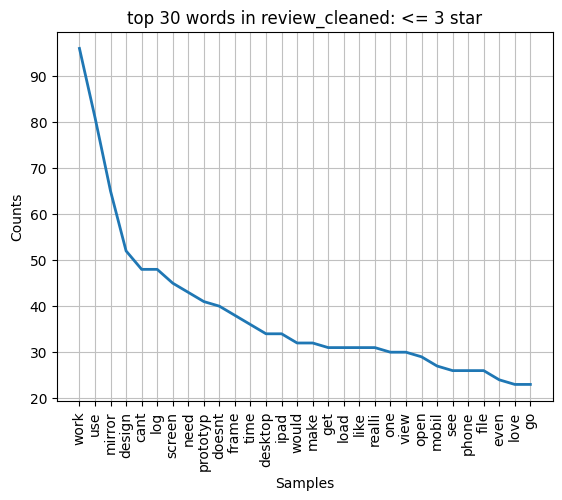

In [9]:
df_backup = df
    
def show_common_words_for_rating_range(num_words, rating_score, text_field, df):
    df_subset = df[df['rating_score'] <= rating_score] 
    words = df_subset[text_field].apply(pd.Series).stack()
    words_freq = FreqDist(words)
    graph_title = f'top {num_words} words in {text_field}: <= {rating_score} star'
    words_freq.plot(num_words, title=graph_title)
    
num_words = 20
    
show_common_words_for_rating_range(30, 3, 'review_cleaned', df)


In [10]:
# now we want to be able to read specific reviews to 1) sanity check and 2) look at context about words like
# would & isn't. "would love" may end up as a hit for would + love but has a negative sentiment


# this cell is a working one, may change often, using it to do different analysis at different points in time
# please do not take anything below here as a finished or ready piece of work

def get_review_text_with_word(word, text_field, score, df):
    df_subset = df[df['rating_score'] <= score]
    df_subset['search_field'] = df_subset[text_field].astype(str)
    df_subset['has_word'] = df_subset['search_field'].str.contains(word)
    results = df_subset[df_subset['has_word']]['review_text']
    
    return results

def how_many_reviews_have_word(word):
    results = get_review_text_with_word(word, 'review_cleaned', 3, df)
    print(f'{len(results)} for {word}')

how_many_reviews_have_word('ipad')

how_many_reviews_have_word('cant')

how_many_reviews_have_word('doesnt')

how_many_reviews_have_word('work')

how_many_reviews_have_word('doesnt')

how_many_reviews_have_word('would')

def show_reviews_with_word(word):
    for review in get_review_text_with_word(word, 'review_cleaned', 3, df):
        print(review + '\n')
        
show_reviews_with_word('ipad')

26 for ipad
39 for cant
34 for doesnt
71 for work
34 for doesnt
23 for would
i love figma on desktop but the mobile app on phone and ipad fall short in a big way.  i use it almost exclusively for the mirror function and i would have given it 3 stars if it weren’t so buggy.    bugs i have found while using mirror include: - loses connection periodically  - freezes often and needs to be restarted  - the prototype doesn’t always appear exactly as on screen.  for example, i had an icon with a transparent container around it and layers that had shadows.  it looked fine on the computer screen but on the phone, the container background appeared white and the shadows were applied to the container instead of the objects inside it.  - it would be nice to have an option to turn on/off status bar and home bar if they are already on your designs.   - animations are not very smooth.   aside from the mirror feature, i wanted to view and respond to a comment while i was on the go, but i can’t see the 

/tmp/ipykernel_39187/3826912107.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['search_field'] = df_subset[text_field].astype(str)
/tmp/ipykernel_39187/3826912107.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['has_word'] = df_subset['search_field'].str.contains(word)
/tmp/ipykernel_39187/3826912107.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 